## Creating Widgets that Navigate through NBA Statistics
By Ashley Radford

Downloading and using nba data from stats.nba.com to create interactive widgets that present plots analyzing the players' shots. This data is used to demonstrate data transformation and visualization via the split-apply-combine approach.

### Data download
The `get_nba_data()` function from the helper_basketball module will be used to download multiple nba datasets that will be needed for the drop down selection widgets. These datasets incude the teams data, player data, and shots data. End visualizations will require specific selected data grabbed from the shots data, which in and of itself will require specific paramaters. Thus, after retrieving our three necessary datasets using the `get_nba_data()` function, we will create another function with three parameters (team id, name id, and game date id). This function will return the necessary parameters for a specifc team, player, and game date for the `get_nba_data()` function used to download shots data. This function, `choose_player_game()`, is tested along with `get_nba_data()` below.

In [1]:
# necessary importations
import numpy as np
import pandas as pd
from ipywidgets import Dropdown, Button
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize
from IPython.display import clear_output
import helper_basketball as h

In [2]:
# lets see what current_year and latest_season we have chocen in the helper_basketball module
print('current year is ' + str(h.current_year))
print('latest season is ' + str(h.latest_season))

current year is 2017
latest season is 2016-17


In [3]:
# getting teams data (refer to endpt comment in above cell for all appropriate parameters)
teams_params = {'LeagueID':'00'}
teams = h.get_nba_data('commonTeamYears', teams_params)
teams.head()

,LEAGUE_ID,TEAM_ID,MIN_YEAR,MAX_YEAR,ABBREVIATION
0,00,1610612737,1949,2018,ATL
1,00,1610612738,1946,2018,BOS
2,00,1610612739,1970,2018,CLE
3,00,1610612740,2002,2018,NOP
4,00,1610612741,1966,2018,CHI


In [4]:
# link that data is pulled from
# http://stats.nba.com/stats/commonTeamYears?LeagueID=00

In [5]:
# getting player data
# not only from specified 2016-17 season in params dictionary 
# can put whatever in Season, not only current season
players_params = {'LeagueID':'00', 'Season': h.latest_season, 'IsOnlyCurrentSeason':'0'}
players = h.get_nba_data('commonallplayers', players_params)
players.head()

,PERSON_ID,DISPLAY_LAST_COMMA_FIRST,DISPLAY_FIRST_LAST,ROSTERSTATUS,FROM_YEAR,TO_YEAR,PLAYERCODE,TEAM_ID,TEAM_CITY,TEAM_NAME,TEAM_ABBREVIATION,TEAM_CODE,GAMES_PLAYED_FLAG
0,76001,"Abdelnaby, Alaa",Alaa Abdelnaby,0,1990,1994,HISTADD_alaa_abdelnaby,0,,,,,Y
1,76002,"Abdul-Aziz, Zaid",Zaid Abdul-Aziz,0,1968,1977,HISTADD_zaid_abdul-aziz,0,,,,,Y
2,76003,"Abdul-Jabbar, Kareem",Kareem Abdul-Jabbar,0,1969,1988,HISTADD_kareem_abdul-jabbar,0,,,,,Y
3,51,"Abdul-Rauf, Mahmoud",Mahmoud Abdul-Rauf,0,1990,2000,mahmoud_abdul-rauf,0,,,,,Y
4,1505,"Abdul-Wahad, Tariq",Tariq Abdul-Wahad,0,1997,2003,tariq_abdul-wahad,0,,,,,Y


In [6]:
# getting shots data
shots_params = {'PlayerID':'0',
                'PlayerPosition':'',
                'Season': h.latest_season,
                'ContextMeasure':'FGA',
                'DateFrom':'',
                'DateTo':'',
                'GameID':'',
                'GameSegment':'',
                'LastNGames':'0',
                'LeagueID':'00',
                'Location':'',
                'Month':'0',
                'OpponentTeamID':'0',
                'Outcome':'',
                'Period':'0',
                'Position':'',
                'RookieYear':'',
                'SeasonSegment':'',
                'SeasonType':'Regular Season',
                'TeamID':'0',
                'VsConference':'',
                'VsDivision':''}

shotdata = h.get_nba_data('shotchartdetail', shots_params)
shotdata.head()

,GRID_TYPE,GAME_ID,GAME_EVENT_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_NAME,PERIOD,MINUTES_REMAINING,SECONDS_REMAINING,...,SHOT_ZONE_AREA,SHOT_ZONE_RANGE,SHOT_DISTANCE,LOC_X,LOC_Y,SHOT_ATTEMPTED_FLAG,SHOT_MADE_FLAG,GAME_DATE,HTM,VTM
0,Shot Chart Detail,0021600001,2,201565,Derrick Rose,1610612752,New York Knicks,1,11,40,...,Center(C),Less Than 8 ft.,0,4,8,1,1,20161025,CLE,NYK
1,Shot Chart Detail,0021600001,3,201567,Kevin Love,1610612739,Cleveland Cavaliers,1,11,26,...,Center(C),Less Than 8 ft.,3,-11,36,1,0,20161025,CLE,NYK
2,Shot Chart Detail,0021600001,5,2546,Carmelo Anthony,1610612752,New York Knicks,1,11,16,...,Right Side Center(RC),16-24 ft.,19,148,129,1,0,20161025,CLE,NYK
3,Shot Chart Detail,0021600001,7,204001,Kristaps Porzingis,1610612752,New York Knicks,1,11,15,...,Center(C),Less Than 8 ft.,2,24,-1,1,1,20161025,CLE,NYK
4,Shot Chart Detail,0021600001,8,2544,LeBron James,1610612739,Cleveland Cavaliers,1,10,59,...,Left Side(L),8-16 ft.,11,-79,80,1,1,20161025,CLE,NYK


In [7]:
# function using the widgets selections
def choose_player_game(teamid, playerid='0', gameid=None):
    if teamid == None: teamid = '0'
    if playerid == None: playerid = '0'
    if gameid == None: gameid = ''
    chosen_params = {'PlayerID':playerid,
                     'PlayerPosition':'',
                     'Season': h.latest_season,
                     'ContextMeasure':'FGA',
                     'DateFrom':'',
                     'DateTo':'',
                     'GameID':gameid,
                     'GameSegment':'',
                     'LastNGames':'0',
                     'LeagueID':'00',
                     'Location':'',
                     'Month':'0',
                     'OpponentTeamID':'0',
                     'Outcome':'',
                     'Period':'0',
                     'Position':'',
                     'RookieYear':'',
                     'SeasonSegment':'',
                     'SeasonType':'Regular Season',
                     'TeamID':teamid,
                     'VsConference':'',
                     'VsDivision':''}
    return chosen_params

# test function for parameters Golden State Warriors, Stephen Curry, and 10/25/2016 game
# only works when h.current_year is 2017 and h.latest_season is 2016-17
player_game = h.get_nba_data('shotchartdetail', choose_player_game('1610612744', '201939', '0021600003'))
player_game.head()

,GRID_TYPE,GAME_ID,GAME_EVENT_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_NAME,PERIOD,MINUTES_REMAINING,SECONDS_REMAINING,...,SHOT_ZONE_AREA,SHOT_ZONE_RANGE,SHOT_DISTANCE,LOC_X,LOC_Y,SHOT_ATTEMPTED_FLAG,SHOT_MADE_FLAG,GAME_DATE,HTM,VTM
0,Shot Chart Detail,0021600003,19,201939,Stephen Curry,1610612744,Golden State Warriors,1,9,2,...,Right Side Center(RC),24+ ft.,28,130,257,1,0,20161025,GSW,SAS
1,Shot Chart Detail,0021600003,28,201939,Stephen Curry,1610612744,Golden State Warriors,1,8,6,...,Right Side Center(RC),24+ ft.,25,189,174,1,1,20161025,GSW,SAS
2,Shot Chart Detail,0021600003,88,201939,Stephen Curry,1610612744,Golden State Warriors,1,2,23,...,Right Side Center(RC),24+ ft.,27,159,229,1,0,20161025,GSW,SAS
3,Shot Chart Detail,0021600003,91,201939,Stephen Curry,1610612744,Golden State Warriors,1,2,1,...,Right Side Center(RC),16-24 ft.,21,163,141,1,0,20161025,GSW,SAS
4,Shot Chart Detail,0021600003,184,201939,Stephen Curry,1610612744,Golden State Warriors,2,6,47,...,Center(C),24+ ft.,26,-9,267,1,1,20161025,GSW,SAS


### Subsetting and cleaning data for widget creation
Later we will be creating the 3 widgets that will be used to pull data with the `chose_player_game()` and `get_nba_data()` functions. However, we first want to set up the data types and make sure to subset only the current teams and active players (players who played at least one game in the selected season) for our drop down selections. This is because we plan to have the following widgets: first one to select the team, then one to pick a player from the selected team, and then a third to pick a specific game that that player took shots in. We will do a check of the data and then follow with some more data clean up.

In [8]:
# setting up series types
teams.ABBREVIATION = teams.ABBREVIATION.astype('category')
teams.TEAM_ID      = teams.TEAM_ID.astype('category')
teams.MIN_YEAR     = teams.MIN_YEAR.astype('int')
teams.MAX_YEAR     = teams.MAX_YEAR.astype('int')

# taking current teams
teams = teams[(teams.MIN_YEAR <= (h.current_year-1)) & (teams.MAX_YEAR >= h.current_year)]
# taking current and active players
players = players[players.TEAM_ID.isin(teams.TEAM_ID) & players.PERSON_ID.isin(shotdata.PLAYER_ID)]
# taking active players shotdata
shotdata = shotdata[shotdata.PLAYER_ID.isin(players.PERSON_ID)]

In [9]:
# checking teams data
teams.head()

,LEAGUE_ID,TEAM_ID,MIN_YEAR,MAX_YEAR,ABBREVIATION
0,00,1610612737,1949,2018,ATL
1,00,1610612738,1946,2018,BOS
2,00,1610612739,1970,2018,CLE
3,00,1610612740,2002,2018,NOP
4,00,1610612741,1966,2018,CHI


In [10]:
# checking players data
players.head()

,PERSON_ID,DISPLAY_LAST_COMMA_FIRST,DISPLAY_FIRST_LAST,ROSTERSTATUS,FROM_YEAR,TO_YEAR,PLAYERCODE,TEAM_ID,TEAM_CITY,TEAM_NAME,TEAM_ABBREVIATION,TEAM_CODE,GAMES_PLAYED_FLAG
9,203518,"Abrines, Alex",Alex Abrines,1,2016,2018,alex_abrines,1610612760,Oklahoma City,Thunder,OKC,thunder,Y
14,203112,"Acy, Quincy",Quincy Acy,1,2012,2017,quincy_acy,1610612751,Brooklyn,Nets,BKN,nets,Y
21,203500,"Adams, Steven",Steven Adams,1,2013,2018,steven_adams,1610612760,Oklahoma City,Thunder,OKC,thunder,Y
26,201167,"Afflalo, Arron",Arron Afflalo,1,2007,2017,arron_afflalo,1610612758,Sacramento,Kings,SAC,kings,Y
31,201582,"Ajinca, Alexis",Alexis Ajinca,1,2008,2017,alexis_ajinca,1610612740,New Orleans,Pelicans,NOP,pelicans,Y


In [11]:
# checking shots 
shotdata.head()

,GRID_TYPE,GAME_ID,GAME_EVENT_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_NAME,PERIOD,MINUTES_REMAINING,SECONDS_REMAINING,...,SHOT_ZONE_AREA,SHOT_ZONE_RANGE,SHOT_DISTANCE,LOC_X,LOC_Y,SHOT_ATTEMPTED_FLAG,SHOT_MADE_FLAG,GAME_DATE,HTM,VTM
0,Shot Chart Detail,0021600001,2,201565,Derrick Rose,1610612752,New York Knicks,1,11,40,...,Center(C),Less Than 8 ft.,0,4,8,1,1,20161025,CLE,NYK
1,Shot Chart Detail,0021600001,3,201567,Kevin Love,1610612739,Cleveland Cavaliers,1,11,26,...,Center(C),Less Than 8 ft.,3,-11,36,1,0,20161025,CLE,NYK
2,Shot Chart Detail,0021600001,5,2546,Carmelo Anthony,1610612752,New York Knicks,1,11,16,...,Right Side Center(RC),16-24 ft.,19,148,129,1,0,20161025,CLE,NYK
3,Shot Chart Detail,0021600001,7,204001,Kristaps Porzingis,1610612752,New York Knicks,1,11,15,...,Center(C),Less Than 8 ft.,2,24,-1,1,1,20161025,CLE,NYK
4,Shot Chart Detail,0021600001,8,2544,LeBron James,1610612739,Cleveland Cavaliers,1,10,59,...,Left Side(L),8-16 ft.,11,-79,80,1,1,20161025,CLE,NYK


### Adding in some columns for later convenience
Eventually, we are going to want to take the name of a team from the teams dataframe for convenience. Thus, we will create a `TEAM_NAME` column in the 'teams' dataframe. We will do this by using the merging in the `TEAM_NAME` column from the `players` dataframe.

In [12]:
# creating TEAM_NAME column on teams by merging data from players
team_names = players[['TEAM_ABBREVIATION', 'TEAM_NAME']].copy().drop_duplicates()
teams = pd.merge(teams, team_names, left_on='ABBREVIATION', right_on='TEAM_ABBREVIATION')

# getting rid of TEAM_ABBREVIATION column
teams = teams.drop(['TEAM_ABBREVIATION'], axis=1) # only returns values, so needs to be reassigned
teams.head()

,LEAGUE_ID,TEAM_ID,MIN_YEAR,MAX_YEAR,ABBREVIATION,TEAM_NAME
0,00,1610612737,1949,2018,ATL,Hawks
1,00,1610612738,1946,2018,BOS,Celtics
2,00,1610612739,1970,2018,CLE,Cavaliers
3,00,1610612740,2002,2018,NOP,Pelicans
4,00,1610612741,1966,2018,CHI,Bulls


### Creating a useful function for current and later use
In the following code, the function `readable_data()` is created to allow for proper formating of the game dates that are in `shotdata.`

In [13]:
# creating readable dates function
def readable_date(date):
    mm = date[4:6]
    dd = date[6:]
    yyyy = date[:4]
    readable = mm+'/'+dd+'/'+yyyy
    return readable

# changing the GAME_DATE column in shotdata
temp = []
for date in shotdata.GAME_DATE:
    read_date = readable_date(date)
    temp += [read_date]

shotdata['GAME_DATE'] = temp

### Something to consider
Before continuing, it is important that we understand our data. 

In [14]:
print(shotdata.dtypes)

GRID_TYPE              object
GAME_ID                object
GAME_EVENT_ID           int64
PLAYER_ID               int64
PLAYER_NAME            object
TEAM_ID                 int64
TEAM_NAME              object
PERIOD                  int64
MINUTES_REMAINING       int64
SECONDS_REMAINING       int64
EVENT_TYPE             object
ACTION_TYPE            object
SHOT_TYPE              object
SHOT_ZONE_BASIC        object
SHOT_ZONE_AREA         object
SHOT_ZONE_RANGE        object
SHOT_DISTANCE           int64
LOC_X                   int64
LOC_Y                   int64
SHOT_ATTEMPTED_FLAG     int64
SHOT_MADE_FLAG          int64
GAME_DATE              object
HTM                    object
VTM                    object
dtype: object


In [15]:
# getting other teams        
player_other_dd = dict()
for p, data in shotdata.groupby('PLAYER_NAME'):
    all_teams = np.unique(shotdata.loc[shotdata['PLAYER_NAME']==p]['TEAM_ID']) # grab all of their teams (dont need .copy() because multi-dtype)
    if len(all_teams) > 1:
        current_team = shotdata.loc[shotdata['PLAYER_NAME']==p]['TEAM_ID'].values[-1] # grab their current team (ordered by date)
        other_teams = all_teams[np.where(all_teams!=current_team)]                    # only grab previous teams
        player_other_dd[p] = other_teams                                              # create dict keys and values

player_other_dd

{'Andrew Nicholson': array([1610612764]),
 'Anthony Morrow': array([1610612760]),
 'Archie Goodwin': array([1610612740]),
 'Axel Toupane': array([1610612749]),
 'Bojan Bogdanovic': array([1610612751]),
 'Brandon Jennings': array([1610612752]),
 'Briante Weber': array([1610612744]),
 'Buddy Hield': array([1610612740]),
 'Cameron Payne': array([1610612760]),
 'Chasson Randle': array([1610612755]),
 'Chris McCullough': array([1610612751]),
 'Corey Brewer': array([1610612745]),
 'DeAndre Liggins': array([1610612739]),
 'DeMarcus Cousins': array([1610612758]),
 'Deron Williams': array([1610612742]),
 'Derrick Williams': array([1610612748]),
 'Doug McDermott': array([1610612741]),
 'Edy Tavares': array([1610612737]),
 'Ersan Ilyasova': array([1610612755, 1610612760]),
 'Jerami Grant': array([1610612755]),
 'Joffrey Lauvergne': array([1610612760]),
 "Johnny O'Bryant III": array([1610612743]),
 'Jose Calderon': array([1610612747]),
 'Justin Anderson': array([1610612742]),
 'Jusuf Nurkic': arra

In [16]:
# creating player_other dataframe
player_other = pd.DataFrame({
                 'player': list(player_other_dd.keys()),
                 'previous_team': list(player_other_dd.values())
               })

# seperating the extra games teams (if they had more than 2 teams in a season)
for i, l in enumerate(player_other['previous_team']):
    player_other['previous_team'][i] = l[0]                # taking string from first positioned team
    c=0                                                    # to help with new index count
    if len(l) > 1:                                         # if they have more than 1 other team
        l = (l[1:])                                        # not considering first other team
        for t in l:
            extra = pd.DataFrame({
                      'player': player_other['player'][i], # grabbing player
                      'previous_team': t                   # grabbing all other teams seperately
                    }, index = [len(player_other)+c])      # getting new idexes
            player_other = player_other.append(extra)      # appending the extra dataframe
            c+=1
            
# sorting player_other alphabetically and resetting indices numbers
player_other = player_other.sort_values('player').reset_index(drop=True) 
player_other.head()

,player,previous_team
0,Andrew Nicholson,1610612764
1,Anthony Morrow,1610612760
2,Archie Goodwin,1610612740
3,Axel Toupane,1610612749
4,Bojan Bogdanovic,1610612751


In [17]:
# creating other_teams dataframe from player dataframe (to append onto later)
other_teams = pd.DataFrame()
for player in player_other_dd.keys():
    for i in range(len(player_other_dd[player])):
        # grabbing the additional row
        new_row = players[players['DISPLAY_FIRST_LAST']==player].copy()
        index = new_row.index[0] # finding index label
        
        # changing team columns
        team_id = player_other_dd[player][i]
        
        # updating the team columns
        new_row.loc[index,'TEAM_ID'] = team_id
        new_row.loc[index,'TEAM_NAME'] = teams['TEAM_NAME'][np.where(teams['TEAM_ID']==team_id)[0][0]]
        new_row.loc[index,'TEAM_ABBREVIATION'] = teams['ABBREVIATION'][np.where(teams['TEAM_ID']==team_id)[0][0]]
        new_row.loc[index,'TEAM_CITY'] = players['TEAM_CITY'][players.index[np.where(players['TEAM_ID']==team_id)[0][0]]]
        new_row.loc[index,'TEAM_CODE'] = players['TEAM_CODE'][players.index[np.where(players['TEAM_ID']==team_id)[0][0]]]
        
        # adding the updated column
        other_teams = other_teams.append(new_row)
    
other_teams[17:22]

,PERSON_ID,DISPLAY_LAST_COMMA_FIRST,DISPLAY_FIRST_LAST,ROSTERSTATUS,FROM_YEAR,TO_YEAR,PLAYERCODE,TEAM_ID,TEAM_CITY,TEAM_NAME,TEAM_ABBREVIATION,TEAM_CODE,GAMES_PLAYED_FLAG
3778,204002,"Tavares, Edy",Edy Tavares,1,2015,2016,edy_tavares,1610612737,Atlanta,Hawks,ATL,hawks,Y
1834,101141,"Ilyasova, Ersan",Ersan Ilyasova,1,2006,2018,ersan_ilyasova,1610612755,Philadelphia,76ers,PHI,sixers,Y
1834,101141,"Ilyasova, Ersan",Ersan Ilyasova,1,2006,2018,ersan_ilyasova,1610612760,Oklahoma City,Thunder,OKC,thunder,Y
1435,203924,"Grant, Jerami",Jerami Grant,1,2014,2018,jerami_grant,1610612755,Philadelphia,76ers,PHI,sixers,Y
2256,203530,"Lauvergne, Joffrey",Joffrey Lauvergne,1,2014,2017,joffrey_lauvergne,1610612760,Oklahoma City,Thunder,OKC,thunder,Y


In [18]:
# appending other_teams onto players dataframe and sorting
players = players.append(other_teams).sort_values('DISPLAY_LAST_COMMA_FIRST')
players.head(9)

,PERSON_ID,DISPLAY_LAST_COMMA_FIRST,DISPLAY_FIRST_LAST,ROSTERSTATUS,FROM_YEAR,TO_YEAR,PLAYERCODE,TEAM_ID,TEAM_CITY,TEAM_NAME,TEAM_ABBREVIATION,TEAM_CODE,GAMES_PLAYED_FLAG
9,203518,"Abrines, Alex",Alex Abrines,1,2016,2018,alex_abrines,1610612760,Oklahoma City,Thunder,OKC,thunder,Y
14,203112,"Acy, Quincy",Quincy Acy,1,2012,2017,quincy_acy,1610612742,Dallas,Mavericks,DAL,mavericks,Y
14,203112,"Acy, Quincy",Quincy Acy,1,2012,2017,quincy_acy,1610612751,Brooklyn,Nets,BKN,nets,Y
21,203500,"Adams, Steven",Steven Adams,1,2013,2018,steven_adams,1610612760,Oklahoma City,Thunder,OKC,thunder,Y
26,201167,"Afflalo, Arron",Arron Afflalo,1,2007,2017,arron_afflalo,1610612758,Sacramento,Kings,SAC,kings,Y
31,201582,"Ajinca, Alexis",Alexis Ajinca,1,2008,2017,alexis_ajinca,1610612740,New Orleans,Pelicans,NOP,pelicans,Y
39,202332,"Aldrich, Cole",Cole Aldrich,1,2010,2017,cole_aldrich,1610612750,Minnesota,Timberwolves,MIN,timberwolves,Y
40,200746,"Aldridge, LaMarcus",LaMarcus Aldridge,1,2006,2018,lamarcus_aldridge,1610612759,San Antonio,Spurs,SAS,spurs,Y
55,202730,"Allen, Lavoy",Lavoy Allen,1,2011,2016,lavoy_allen,1610612754,Indiana,Pacers,IND,pacers,Y


### Creating dictonaries for the widget drop down menus
Now, three dictionaries will be created from each dataset. We will first create a dictionary containing the team name and mascot as the keys, where the value will be their team id. The second dictionary will have teamids as its keys and dictionaries as its values. These dictonary values will have player names as its keys and the corresponding playerid as its value. Finally, the third dictionary will have playerid as its keys and will have dictionaries as its values too. These dictionary values will have game dates as its keys and the corresponding datids for its values. Later, all the id keys from each of these three dictonaries will be used to fetch the wanted data using the `choose_player_game()` function.

In [19]:
# getting dictionaries ready for the widgets
# creating (team: teamid) dictionary
teams = teams.sort_values('ABBREVIATION') # sorting teams by abbreviation
team_dd_text = teams.ABBREVIATION + ', ' + teams.TEAM_NAME
team_dd = dict(zip(team_dd_text, teams.TEAM_ID))

# creating players by team dictionary
# teamid: {player: personid})
players = players.sort_values('DISPLAY_FIRST_LAST') # sorting players by first name
plyr_by_team_dd = dict()
for t, p in players.groupby('TEAM_ID'):
    plyr_by_team_dd[t] = dict(zip(p.DISPLAY_FIRST_LAST, p.PERSON_ID))

# creating games by player dictionary
# (personid, teamid): {game date: gameid}
game_by_player_dd = dict()
for p, g in shotdata.groupby(['PLAYER_ID','TEAM_ID']):
    game_by_player_dd[p] = dict(zip(g.GAME_DATE, g.GAME_ID))

Finally, the interactive widgets will be created. The first will contain all the teams, the second all the players, and the third all the games. They will all act independently from one another as of now.

In [20]:
# creating widgets
# change selected00 and selected01 based on h.current_season (see helper_basketball)
selected00 = 'NOP, Pelicans'
selected01 = 'DeMarcus Cousins'

team_menu = Dropdown(options=team_dd, label=selected00)
plyr_menu = Dropdown(options=plyr_by_team_dd[team_dd[selected00]], label=selected01)
game_menu = Dropdown(options=game_by_player_dd[(plyr_by_team_dd[team_dd[selected00]][selected01], team_dd[selected00])])

display(team_menu, plyr_menu, game_menu)

Dropdown(index=18, options={'ATL, Hawks': 1610612737, 'BKN, Nets': 1610612751, 'BOS, Celtics': 1610612738, 'CH…

Dropdown(index=7, options={'Alexis Ajinca': 201582, 'Anthony Davis': 203076, 'Archie Goodwin': 203462, 'Axel T…

Dropdown(options={'02/23/2017': '0021600852', '02/25/2017': '0021600870', '02/26/2017': '0021600880', '03/03/2…

### Downloading data with changing widget states
Now, event handlers such as `options`, `value`, `observe`, and `on_click` will be added to the previous cell in order to accomodate changes in selections (or the lack of changes). The nested games within the players within the teams will no longer act independently. A fetch button will also be added to allow the user to get the id numbers. The `update_team()` and `update_player()` function will update each dropdown menu as the other dropdown menus are changed. The `get_data()` function will then pull the ids from the dictionaries for each click of the button.

In [21]:
fetch_button = Button(description='Get Data!', icon='check')
display(team_menu, plyr_menu, game_menu, fetch_button)

# update players list
def update_team(change): 
    plyr_menu.options = plyr_by_team_dd[change['new']]
    plyr_menu.value = list(plyr_by_team_dd[change['new']].values())[0]

team_menu.observe(update_team, names='value')

# update game list
def update_player(change):
    if change['new'] != None: # update game from player only when player is changed, ow will do it through above cell
        game_menu.options = game_by_player_dd[(change['new'], team_menu.value)]
        game_menu.value = list(game_by_player_dd[(change['new'], team_menu.value)].values())[0]

plyr_menu.observe(update_player, names='value')

# get data action
# change is a dictionary holding the information about the change
def get_data(change):
    print(team_menu.value, plyr_menu.value, game_menu.value) 
    
fetch_button.on_click(get_data)

Dropdown(index=18, options={'ATL, Hawks': 1610612737, 'BKN, Nets': 1610612751, 'BOS, Celtics': 1610612738, 'CH…

Dropdown(index=7, options={'Alexis Ajinca': 201582, 'Anthony Davis': 203076, 'Archie Goodwin': 203462, 'Axel T…

Dropdown(options={'02/23/2017': '0021600852', '02/25/2017': '0021600870', '02/26/2017': '0021600880', '03/03/2…

Button(description='Get Data!', icon='check', style=ButtonStyle())

### Data transformation and visualization
In the following code, `get_visuals()` will be defined. This function will now be called with the `on_click` handler instead of `get_data()`. To summarize, this function will output two visualizations of the data requested from the dropdown menus. A more in depth description is as follows. First `get_visuals()` will take the ids of the team, player, and date that is selected. Instead of outputting it as before, `get_visuals()` will pass the ids onto `choose_player_game()` which will be passed into `get_nba_data()`. This will be done two seperate times, as each visual requires different information. At this point, data will be retrieved and will be used to create the outputted visualizations. The first visualization will be a bar chart comparing the shots made for each game of the player for the team that is selected (will be grouping by date). The chosen date, as well as its bar, will be highlighted in green. Here, one could examine how the players' shots per game vary as the season goes on. The second visualization will be specific to the date chosen (will be grouping by period). It will plot the percentages of shots made (so it will take into account the shots attempted) at each period (as well as the overtime periods) for the selected game date. Here, one could observe how the player performs as time runs out.

Dropdown(index=14, options={'ATL, Hawks': 1610612737, 'BKN, Nets': 1610612751, 'BOS, Celtics': 1610612738, 'CH…

Dropdown(index=5, options={'Andrew Harrison': 1626150, 'Brandan Wright': 201148, 'Chandler Parsons': 202718, '…

Dropdown(index=19, options={'10/26/2016': '0021600009', '10/29/2016': '0021600028', '10/30/2016': '0021600039'…

Button(description='Get Data!', icon='check', style=ButtonStyle())

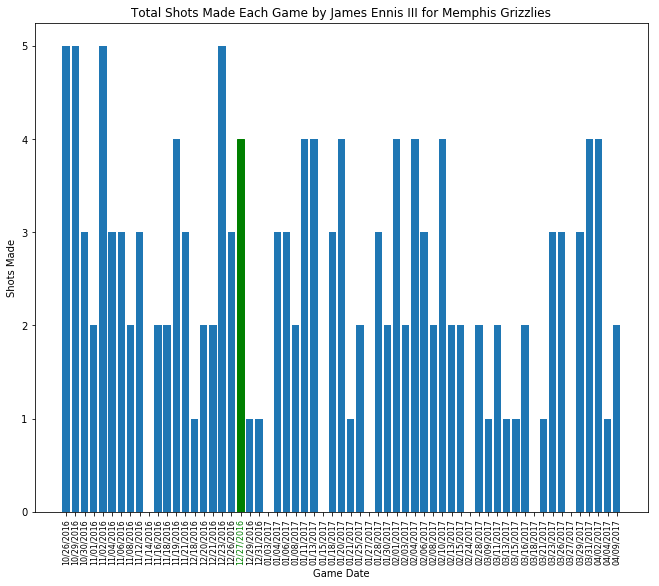

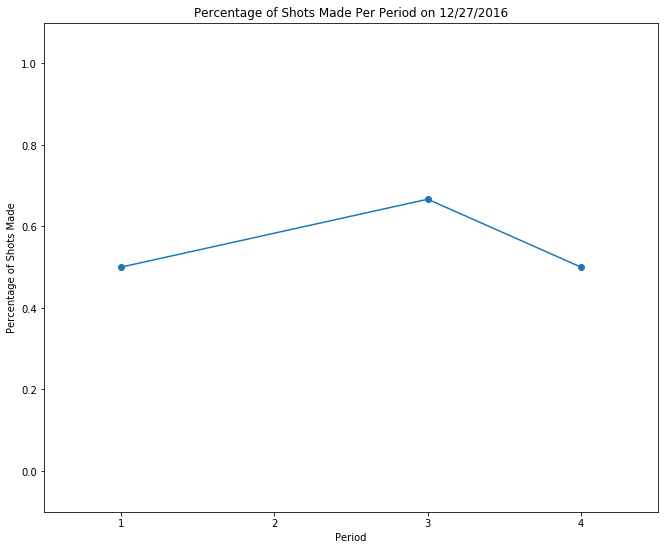

In [22]:
%matplotlib inline
fetch_button = Button(description='Get Data!', icon='check')
display(team_menu, plyr_menu, game_menu, fetch_button)

def get_visuals(change):
    clear_output()
    display(team_menu, plyr_menu, game_menu, fetch_button)
    
    teamid = str(team_menu.value)
    playerid = str(plyr_menu.value)
    gameid = str(game_menu.value)
    
    # getting data set up for plot of total 
    # shots each game for chosen player
    player_shots = h.get_nba_data('shotchartdetail', choose_player_game(teamid, playerid))
    player_shots_dd = dict()
    for d, s in player_shots.groupby('GAME_DATE'):
        player_shots_dd[d] = sum(s.SHOT_MADE_FLAG)
    
    player_shots_df = pd.DataFrame({
                        'game_date': list(player_shots_dd.keys()),
                        'shots_made': list(player_shots_dd.values()),
                      })
    
    # getting game date (from value) to color later
    gameid_index = list(player_shots['GAME_ID']).index(gameid)
    match_date = list(player_shots['GAME_DATE'])[gameid_index]
    date_location = list(player_shots_df.game_date).index(match_date)
    
    # getting prettier dates
    temp = player_shots_df.game_date.copy()
    for i in range(len(temp)):
        read_date = readable_date(temp[i])
        temp[i] = read_date
    player_shots_df['game_date'] = temp
    
    # plotting total shots each game for chosen player
    figsize(11, 9)
    objects = player_shots_df['game_date']
    y_pos = np.arange(len(objects))
    shots_plot = plt.bar(y_pos, player_shots_df['shots_made'], align = 'center')
    plt.xticks(y_pos, objects, rotation=90, fontsize=8);
    
    plt.xlabel("Game Date")
    plt.ylabel("Shots Made")
    plt.title("Total Shots Made Each Game by " + str(list(player_shots['PLAYER_NAME'])[0]) 
              + " for " + str(list(player_shots['TEAM_NAME'])[0]))
    
    # coloring specific date bar and label
    shots_plot.get_children()[date_location].set_color('g') 
    plt.gca().get_xticklabels()[date_location].set_color('g')
    
    plt.show() # to show both graphs
    
    # getting data set up for percentage of shots
    # made in each period for chosen game    
    period_percentage = h.get_nba_data('shotchartdetail', choose_player_game(teamid, playerid, gameid))
    period_percentage_dd = dict()
    for p, s in period_percentage.groupby('PERIOD'):
        period_percentage_dd[p] = sum(s.SHOT_MADE_FLAG) / sum(s.SHOT_ATTEMPTED_FLAG)
    
    period_percentage_df = pd.DataFrame({
                        'period': sorted(list(period_percentage_dd.keys())),
                        'percentage_made': list(period_percentage_dd.values()),    
                      })
    
    # plotting percentage of shots made in each period for chosen game
    plt.plot((period_percentage_df['period']), period_percentage_df['percentage_made'], '-o')
    plt.xlabel("Period")
    plt.ylabel("Percentage of Shots Made")
    plt.title("Percentage of Shots Made Per Period on " + str(readable_date(match_date)))
    
    ticks=[1,2,3,4]
    ot = [] # for overtime periods
    quarters = list(period_percentage.PERIOD.unique()) # quarters where shots were taken
    for i in quarters: # getting possible overtime periods
        if i > 4:
            ot.append(i)
    if len(ot) != 0:
        ticks += ot
    
    plt.xticks(ticks)
    plt.xlim((0.5,ticks[-1] + 0.5))
    plt.ylim((-0.1,1.1))
    
player_shots = fetch_button.on_click(get_visuals)